In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import math
import os
import flammkuchen as fl

# Image
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [4]:
from fig_1_helper import labels_cat, color, color_bouts, cmp_bouts
from fig_1_helper import mid_head
from fig_1_helper import compute_tailsum, clean_tail, exptrapolate_segments

In [ ]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


## Load data

In [5]:
figure_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_1\supp\suppl_3')
figure_path

WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Figure_1/supp/suppl_3')

In [6]:
path_features = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\features_bouts_new.csv')
path_features

WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new.csv')

# Import all the pretty raw data 

In [7]:
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_proba,max_eye_rot,...,tail_freq,l_fin_freqs,r_fin_freqs,tail_max_freq,l_fin_max_freqs,r_fin_max_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,0.806645,-0.239648,...,0.121622,0.105263,0.109756,0.166667,0.166667,0.166667,0.0,27.0,0.0,28.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,1.000000,0.479035,...,0.058140,0.117647,0.119048,0.166667,0.166667,0.250000,0.0,15.0,7.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,1.000000,-1.120168,...,0.097561,0.115385,0.104167,0.166667,0.166667,0.125000,4.0,20.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,1.000000,-2.662451,...,0.114286,0.117647,0.117647,0.166667,0.166667,0.125000,19.0,35.0,0.0,35.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,1.000000,-1.192489,...,0.108108,0.116667,0.103448,0.166667,0.125000,0.125000,0.0,23.0,6.0,28.0


In [8]:
fish_path = Path(r'\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3')
fish_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3')

In [9]:
vid_path = list(fish_path.glob('*video*'))[0]
vid_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3/120328_video.mp4')

### Load data

In [12]:
data = fl.load(fish_path /'megabouts_res.h5')
data = data['data']

bout_category = data['bout_category']
body_angle = data['body_angle']
left_eye_angle = data['eye_angles'][0]
right_eye_angle = data['eye_angles'][1]
left_fin_angle  = data['fin_angles'][0]
right_fin_angle = data['fin_angles'][1]
vergence = data['vergence']
rotation = data['rotation']
bout_starts = data['segments_on']
bout_ends = data['segments_off']
tail = data['clean_data_tail']

tailsum = compute_tailsum(tail)

In [13]:
bout_categories =[]

# get bout categories
bout_cat = ([x-11 if x >=11 else x for x in data['bout_category']])
bout_categories.append(np.asarray(bout_cat))
bout_categories_flat = [item for sublist in bout_categories for item in sublist]

(424, (175,))

In [15]:
smoothed_l_fin = savgol_filter(left_fin_angle, 5, 2)  # window size 5, polynomial order 2
smoothed_r_fin = savgol_filter(right_fin_angle, 5, 2)  # window size 5, polynomial order 2

In [16]:
smoothed_l_eye = savgol_filter(left_eye_angle, 5, 1)  # window size 5, polynomial order 2
smoothed_r_eye = savgol_filter(right_eye_angle, 5, 1)  # window size 5, polynomial order 2

In [ ]:
fps=200
bout_duration = 50
threshold = 0.99

In [19]:
fish_id = os.path.basename(fish_path)
filename = list(fish_path.glob('*316000.h5*'))[0]
print (filename, fish_id)
df= pd.read_hdf(filename,  header=[1, 2], index_col=0)
df = df['DLC_resnet50_dlc_2Dec12shuffle1_316000']
df_orig = df.copy()
df_filter = df[df_orig.body.likelihood >=threshold]

print(f'{df.shape[0]/(fps*60)} minutes at {fps} fps')

\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3\120328_videoDLC_resnet50_dlc_2Dec12shuffle1_316000.h5 120328_f3
8.31575 minutes at 200 fps


In [20]:
body_x = df.body.x.values
body_y = df.body.y.values

In [22]:
eye_coords = fl.load(fish_path/'eye_coords.h5')
eye_coords = eye_coords['eye_coords']

left_eye_points = np.asarray(eye_coords)[:,0]
right_eye_points = np.asarray(eye_coords)[:,1]

l_anterior = np.asarray(left_eye_points[:,0])
l_posterior = np.asarray(left_eye_points[:,1])

left_eye_anterior_x = []
left_eye_anterior_y = []
left_eye_posterior_x = []
left_eye_posterior_y = []
for i in range(l_anterior.shape[0]):
    left_eye_anterior_x.append(l_anterior[i][0])
    left_eye_anterior_y.append(l_anterior[i][1])
    left_eye_posterior_x.append(l_posterior[i][0])
    left_eye_posterior_y.append(l_posterior[i][1])
    
r_anterior = np.asarray(right_eye_points[:,0])
r_posterior = np.asarray(right_eye_points[:,1])

right_eye_anterior_x = []
right_eye_anterior_y = []
right_eye_posterior_x = []
right_eye_posterior_y = []
for i in range(r_anterior.shape[0]):
    right_eye_anterior_x.append(r_anterior[i][0])
    right_eye_anterior_y.append(r_anterior[i][1])
    right_eye_posterior_x.append(r_posterior[i][0])
    right_eye_posterior_y.append(r_posterior[i][1])


#Extract angles
body_x = df.body.values[:, 0].astype('float')
body_y = df.body.values[:, 1].astype('float')
tail_x_col = [f'tail_{i}' for i in range(5)]
tail_y_col = [f'tail_{i}' for i in range(5)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col])
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col])

#clean tail data 
new_tail_x, new_tail_y = clean_tail(tail_x, tail_y, rolling=False,  wnd=5, thresh=100)

#Preprocess data 
tail_x_10, tail_y_10 = exptrapolate_segments(new_tail_x, new_tail_y, 10)

# fin angle computations
right_fin_tip_x =  df['right_fin_tip'].values[:, 0].astype('float')
right_fin_tip_y =  df['right_fin_tip'].values[:, 1].astype('float')
right_fin_base_x =  df['right_fin_base'].values[:, 0].astype('float')
right_fin_base_y =  df['right_fin_base'].values[:, 1].astype('float')

left_fin_tip_x =  df['left_fin_tip'].values[:, 0].astype('float')
left_fin_tip_y =  df['left_fin_tip'].values[:, 1].astype('float')
left_fin_base_x =   df['left_fin_base'].values[:, 0].astype('float')
left_fin_base_y =   df['left_fin_base'].values[:, 1].astype('float')

mid_headx, mid_heady, left_mid_eye_x, left_mid_eye_y, right_mid_eye_x, right_mid_eye_y = mid_head(df)


### Set some parameters

In [23]:
center_y = 512 #268  #from camera
center_x = 640 #360  #from camera
px_mm = 70 #150 #70

In [24]:
contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)
alph=0.01
size=1
cm_ = 1/2.54  # centimeters in inches
f_size =6
lw=0.5
dpi=600

# Load Video Frames

In [25]:
## Read in chunk of video 

frame_n = 5000

frames= []

cap = cv2.VideoCapture(str(vid_path))
for i in tqdm(range(frame_n)):
    success = cap.grab()
    ret, image = cap.retrieve()
    frames.append(image)
    
cap.release()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 239.08it/s]


# Panel A: Spot avoidance turn

In [106]:
#Get the frames where bouts start 
bout = 1
bout_frame = df[df.body.likelihood >=threshold].index[data['segments_on'][bout]]
print (bout_frame)
print (bout_cat[bout])
i = bout_frame + 5

4084
7


In [107]:
chosen_inds = np.arange(4, 34, 2)
print (chosen_inds, len(chosen_inds))

[ 4  6  8 10 12 14 16 18 20 22 24 26 28 30 32] 15


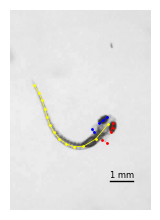

In [108]:
i = bout_frame + 5
# call addWeighted function. use beta = 0 to effectively only
out = cv2.addWeighted(frames[i], contrast, frames[i], 0, brightness)

plt.figure(figsize=(5*cm_, 6.6*cm_), facecolor='None')
plt.imshow(frames[i])
plt.imshow(out, origin='lower')

plt.plot([right_eye_anterior_x[i],right_eye_posterior_x[i]],[right_eye_anterior_y[i],right_eye_posterior_y[i]],'r', lw=lw)
plt.scatter(right_mid_eye_x[i],right_mid_eye_y[i],s=size,color='r', label='right eye')
plt.scatter(right_eye_anterior_x[i],right_eye_anterior_y[i], s=size,color='r')
plt.scatter(right_eye_posterior_x[i],right_eye_posterior_y[i], s=size,color='r')

plt.plot([left_eye_anterior_x[i],left_eye_posterior_x[i]],[left_eye_anterior_y[i],left_eye_posterior_y[i]],'b', lw=lw)
plt.scatter(left_mid_eye_x[i],left_mid_eye_y[i], s=size,color='b', label='left eye')
plt.scatter(left_eye_anterior_x[i],left_eye_anterior_y[i], s=size,color='b')
plt.scatter(left_eye_posterior_x[i],left_eye_posterior_y[i], s=size,color='b')

plt.scatter(left_fin_tip_x[i],left_fin_tip_y[i], s=size,color='b')
plt.scatter(left_fin_base_x[i],left_fin_base_y[i], s=size,color='b')
plt.scatter(right_fin_tip_x[i],right_fin_tip_y[i], s=size,color='r')
plt.scatter(right_fin_base_x[i],right_fin_base_y[i], s=size,color='r')
plt.plot([left_fin_tip_x[i], left_fin_base_x[i]],[left_fin_tip_y[i], left_fin_base_y[i]],'b' ,ls=':', lw=lw)
plt.plot([right_fin_tip_x[i], right_fin_base_x[i]],[right_fin_tip_y[i], right_fin_base_y[i]],'r' ,ls=':', lw=lw)

plt.scatter(body_x[i],body_y[i],s=size,color='yellow')
plt.scatter(mid_headx[i],mid_heady[i],s=size,color='yellow')
plt.plot([mid_headx[i], body_x[i]],[mid_heady[i], body_y[i]],'yellow', lw=lw)
plt.plot([tail_x_10[0,i], body_x[i]],[tail_y_10[0,i], body_y[i]],'yellow', lw=lw)

for i_seg in range(tail_x_10.shape[0]):
    plt.scatter(tail_x_10[i_seg,i],tail_y_10[i_seg,i],s=size, color='yellow')

for i_seg in range(tail_x_10.shape[0]-1):
    plt.plot([tail_x_10[i_seg,i], tail_x_10[i_seg+1,i]],[tail_y_10[i_seg,i], tail_y_10[i_seg+1,i]], color='yellow', lw=lw)

plt.ylim(330,950)
plt.xlim(960, 525)
plt.plot([580, 580+70], [420, 420], lw=lw*2, c='k')
plt.text(650, 430, '1 mm', fontsize=f_size)
plt.axis('off')

plt.savefig(figure_path/'keypoints_skeleton_{}.png'.format(i), dpi = 500)
plt.savefig(figure_path/'keypoints_skeleton_{}.pdf'.format(i), dpi = 500)

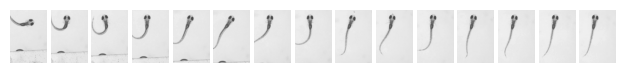

In [109]:

fig, axes = plt.subplots(1, len(chosen_inds), facecolor='None',figsize=(15.4*cm_, 2.6*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')
    ax.set_xlim(body_x[frame_n] + 140, body_x[frame_n] - 200)
    ax.set_ylim(body_y[frame_n] - 350, body_y[frame_n] + 140)
    ax.axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.pdf', dpi=dpi)


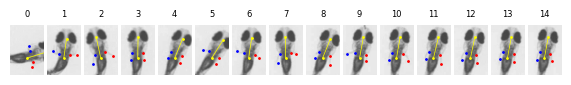

In [110]:
fig, axes = plt.subplots(1, len(chosen_inds),  facecolor='None',figsize=(14*cm_, 2*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')

    ax.scatter(body_x[frame_n], body_y[frame_n], c='yellow', s=size)
    ax.scatter(mid_headx[frame_n], mid_heady[frame_n], c='yellow', s=size)
    ax.plot([mid_headx[frame_n], body_x[frame_n]],[mid_heady[frame_n], body_y[frame_n]],'yellow', lw=lw)
    ax.scatter(left_fin_tip_x[frame_n], left_fin_tip_y[frame_n], s=size, color='b')
    ax.scatter(left_fin_base_x[frame_n], left_fin_base_y[frame_n], s=size, color='b')
    ax.scatter(right_fin_tip_x[frame_n], right_fin_tip_y[frame_n], s=size, color='r')
    ax.scatter(right_fin_base_x[frame_n], right_fin_base_y[frame_n], s=size, color='r')
    ax.set_xlim(body_x[frame_n] + 50, body_x[frame_n] - 50)
    ax.set_ylim(body_y[frame_n] - 50, body_y[frame_n] + 100)
    ax.set_title('{}'.format(ax_idx), fontsize=f_size)
    ax.axis('off')
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.pdf', dpi=dpi)


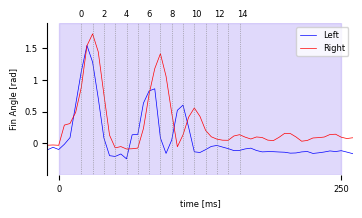

In [111]:
ylim=1.9
alph=0.3
# Calculate the starting frame of the bout
bout_frame_n = df.index[data['segments_on'][bout]]

fig, ax = plt.subplots(figsize=(10*cm_,5*cm_), facecolor='None', sharex=True)
ax.plot(smoothed_l_fin * -1, lw=lw, c='blue', label='Left')
ax.plot(smoothed_r_fin, lw=lw, c='red', label='Right')
ax.set_ylim(-0.5, ylim)
ax.set_ylabel('Fin Angle [rad]', fontsize=f_size)
ax.set_xticks([])

for indx, onset in enumerate(data['segments_on']):
    ax.axvspan(onset, onset + 50, color=color[bout_cat[indx]], alpha=alph)
ax.legend(fontsize=f_size)

for ind, i in enumerate(chosen_inds):
    frame_n = bout_frame_n + i
    ax.axvline(frame_n, c='gray', ls=':', lw=lw)    
    if ind % 2 == 0:  # This will label lines at even indices; use `ind % 2 == 1` for odd indices
        plt.text(frame_n - 0.5, ylim+0.1, ind, rotation=0, fontsize=f_size)

# Set x-axis labels and ticks
ax.set_xlabel('time [ms]', fontsize=f_size)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=f_size)
ax.set_xticks([bout_frame_n, bout_frame_n+50])
ax.set_xticklabels(['0', '250'], fontsize=f_size)
plt.xlim(bout_frame_n-2, bout_frame_n+52)

sns.despine(top=True, right=True, left=False, bottom=True)

fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.pdf', dpi=dpi)


# Panel B: Routine Turn

In [112]:
chosen_inds = np.arange(4, 34, 2)
print (chosen_inds, len(chosen_inds))

[ 4  6  8 10 12 14 16 18 20 22 24 26 28 30 32] 15


In [113]:
#Get the frames where bouts start 
bout = 3
bout_frame = df[df.body.likelihood >=threshold].index[data['segments_on'][bout]]
print (bout_frame)
print (bout_cat[bout])

4534
6


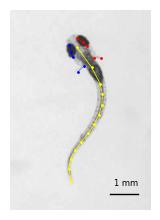

In [114]:
i = bout_frame + 5
out = cv2.addWeighted(frames[i], contrast, frames[i], 0, brightness)

plt.figure(figsize=(5*cm_, 6.6*cm_), facecolor='None')
plt.imshow(frames[i])
plt.imshow(out, origin='lower')

plt.plot([right_eye_anterior_x[i],right_eye_posterior_x[i]],[right_eye_anterior_y[i],right_eye_posterior_y[i]],'r', lw=lw)
plt.scatter(right_mid_eye_x[i],right_mid_eye_y[i],s=size,color='r', label='right eye')
plt.scatter(right_eye_anterior_x[i],right_eye_anterior_y[i], s=size,color='r')
plt.scatter(right_eye_posterior_x[i],right_eye_posterior_y[i], s=size,color='r')

plt.plot([left_eye_anterior_x[i],left_eye_posterior_x[i]],[left_eye_anterior_y[i],left_eye_posterior_y[i]],'b', lw=lw)
plt.scatter(left_mid_eye_x[i],left_mid_eye_y[i], s=size,color='b', label='left eye')
plt.scatter(left_eye_anterior_x[i],left_eye_anterior_y[i], s=size,color='b')
plt.scatter(left_eye_posterior_x[i],left_eye_posterior_y[i], s=size,color='b')

plt.scatter(left_fin_tip_x[i],left_fin_tip_y[i], s=size,color='b')
plt.scatter(left_fin_base_x[i],left_fin_base_y[i], s=size,color='b')
plt.scatter(right_fin_tip_x[i],right_fin_tip_y[i], s=size,color='r')
plt.scatter(right_fin_base_x[i],right_fin_base_y[i], s=size,color='r')
plt.plot([left_fin_tip_x[i], left_fin_base_x[i]],[left_fin_tip_y[i], left_fin_base_y[i]],'b' ,ls=':', lw=lw)
plt.plot([right_fin_tip_x[i], right_fin_base_x[i]],[right_fin_tip_y[i], right_fin_base_y[i]],'r' ,ls=':', lw=lw)

plt.scatter(body_x[i],body_y[i],s=size,color='yellow')
plt.scatter(mid_headx[i],mid_heady[i],s=size,color='yellow')
plt.plot([mid_headx[i], body_x[i]],[mid_heady[i], body_y[i]],'yellow', lw=lw)
plt.plot([tail_x_10[0,i], body_x[i]],[tail_y_10[0,i], body_y[i]],'yellow', lw=lw)

for i_seg in range(tail_x_10.shape[0]):
    plt.scatter(tail_x_10[i_seg,i],tail_y_10[i_seg,i],s=size, color='yellow')

for i_seg in range(tail_x_10.shape[0]-1):
    plt.plot([tail_x_10[i_seg,i], tail_x_10[i_seg+1,i]],[tail_y_10[i_seg,i], tail_y_10[i_seg+1,i]], color='yellow', lw=lw)
    
plt.ylim(100, 600)
plt.xlim(840, 490)
plt.plot([520, 520+70], [140, 140], lw=lw*2, c='k')
plt.text(580, 160, '1 mm', fontsize=f_size)
plt.axis('off')

plt.savefig(figure_path/'keypoints_skeleton_{}.png'.format(i), dpi = dpi)
plt.savefig(figure_path/'keypoints_skeleton_{}.pdf'.format(i), dpi = dpi)

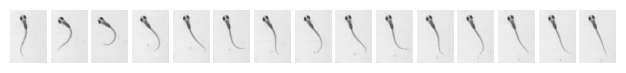

In [115]:

fig, axes = plt.subplots(1, len(chosen_inds), facecolor='None',figsize=(15.4*cm_, 2.6*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')
    ax.set_xlim(body_x[frame_n] + 140, body_x[frame_n] - 200)
    ax.set_ylim(body_y[frame_n] - 350, body_y[frame_n] + 140)
    ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)

fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.pdf', dpi=dpi)


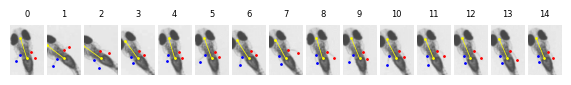

In [116]:
fig, axes = plt.subplots(1, len(chosen_inds),  facecolor='None',figsize=(14*cm_, 2*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')

    ax.scatter(body_x[frame_n], body_y[frame_n], c='yellow', s=size)
    ax.scatter(mid_headx[frame_n], mid_heady[frame_n], c='yellow', s=size)
    ax.plot([mid_headx[frame_n], body_x[frame_n]],[mid_heady[frame_n], body_y[frame_n]],'yellow', lw=lw)
    ax.scatter(left_fin_tip_x[frame_n], left_fin_tip_y[frame_n], s=size, color='b')
    ax.scatter(left_fin_base_x[frame_n], left_fin_base_y[frame_n], s=size, color='b')
    ax.scatter(right_fin_tip_x[frame_n], right_fin_tip_y[frame_n], s=size, color='r')
    ax.scatter(right_fin_base_x[frame_n], right_fin_base_y[frame_n], s=size, color='r')

    ax.set_xlim(body_x[frame_n] + 50, body_x[frame_n] - 50)
    ax.set_ylim(body_y[frame_n] - 50, body_y[frame_n] + 100)
    ax.set_title('{}'.format(ax_idx), fontsize=f_size)
    ax.axis('off')
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)

fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.pdf', dpi=dpi)

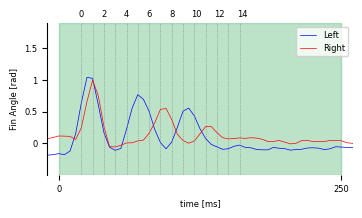

In [117]:
ylim=1.9
alph=0.3
# Calculate the starting frame of the bout
bout_frame_n = df.index[data['segments_on'][bout]]

fig, ax = plt.subplots(figsize=(10*cm_,5*cm_), facecolor='None', sharex=True)
ax.plot(smoothed_l_fin * -1, lw=lw, c='blue', label='Left')
ax.plot(smoothed_r_fin, lw=lw, c='red', label='Right')
ax.set_ylim(-0.5, ylim)
ax.set_ylabel('Fin Angle [rad]', fontsize=f_size)
ax.set_xticks([])
for indx, onset in enumerate(data['segments_on']):
    ax.axvspan(onset, onset + 50, color=color[bout_cat[indx]], alpha=alph)
ax.legend(fontsize=f_size)

for ind, i in enumerate(chosen_inds):
    frame_n = bout_frame_n + i
    ax.axvline(frame_n, c='gray', ls=':', lw=lw)    
    if ind % 2 == 0:  # This will label lines at even indices; use `ind % 2 == 1` for odd indices
        plt.text(frame_n - 0.5, ylim+0.1, ind, rotation=0, fontsize=f_size)

# Set x-axis labels and ticks
ax.set_xlabel('time [ms]', fontsize=f_size)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=f_size)
ax.set_xticks([bout_frame_n, bout_frame_n+50])
ax.set_xticklabels(['0', '250'], fontsize=f_size)

# Define x-axis limits
plt.xlim(bout_frame_n-2, bout_frame_n+52)
sns.despine(top=True, right=True, left=False, bottom=True)

# Save the figure
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.pdf', dpi=dpi)


# Panel C: High angle turn

In [118]:
#Get the frames where bouts start 
bout = 4
bout_frame = df[df.body.likelihood >=threshold].index[data['segments_on'][bout]]
print (bout_frame)
print (bout_cat[bout])

4956
5


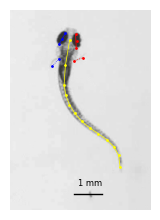

In [119]:
i = bout_frame + 5
# call addWeighted function. use beta = 0 to effectively only
out = cv2.addWeighted(frames[i], contrast, frames[i], 0, brightness)

plt.figure(figsize=(5*cm_, 6.6*cm_), facecolor='None')
plt.imshow(frames[i])
plt.imshow(out, origin='lower')

plt.plot([right_eye_anterior_x[i],right_eye_posterior_x[i]],[right_eye_anterior_y[i],right_eye_posterior_y[i]],'r', lw=lw)
plt.scatter(right_mid_eye_x[i],right_mid_eye_y[i],s=size,color='r', label='right eye')
plt.scatter(right_eye_anterior_x[i],right_eye_anterior_y[i], s=size,color='r')
plt.scatter(right_eye_posterior_x[i],right_eye_posterior_y[i], s=size,color='r')

plt.plot([left_eye_anterior_x[i],left_eye_posterior_x[i]],[left_eye_anterior_y[i],left_eye_posterior_y[i]],'b', lw=lw)
plt.scatter(left_mid_eye_x[i],left_mid_eye_y[i], s=size,color='b', label='left eye')
plt.scatter(left_eye_anterior_x[i],left_eye_anterior_y[i], s=size,color='b')
plt.scatter(left_eye_posterior_x[i],left_eye_posterior_y[i], s=size,color='b')

plt.scatter(left_fin_tip_x[i],left_fin_tip_y[i], s=size,color='b')
plt.scatter(left_fin_base_x[i],left_fin_base_y[i], s=size,color='b')
plt.scatter(right_fin_tip_x[i],right_fin_tip_y[i], s=size,color='r')
plt.scatter(right_fin_base_x[i],right_fin_base_y[i], s=size,color='r')
plt.plot([left_fin_tip_x[i], left_fin_base_x[i]],[left_fin_tip_y[i], left_fin_base_y[i]],'b' ,ls=':', lw=lw)
plt.plot([right_fin_tip_x[i], right_fin_base_x[i]],[right_fin_tip_y[i], right_fin_base_y[i]],'r' ,ls=':', lw=lw)

plt.scatter(body_x[i],body_y[i],s=size,color='yellow')
plt.scatter(mid_headx[i],mid_heady[i],s=size,color='yellow')
plt.plot([mid_headx[i], body_x[i]],[mid_heady[i], body_y[i]],'yellow', lw=lw)
plt.plot([tail_x_10[0,i], body_x[i]],[tail_y_10[0,i], body_y[i]],'yellow', lw=lw)

for i_seg in range(tail_x_10.shape[0]):
    plt.scatter(tail_x_10[i_seg,i],tail_y_10[i_seg,i],s=size, color='yellow')

for i_seg in range(tail_x_10.shape[0]-1):
    plt.plot([tail_x_10[i_seg,i], tail_x_10[i_seg+1,i]],[tail_y_10[i_seg,i], tail_y_10[i_seg+1,i]], color='yellow', lw=lw)
    
plt.ylim(100,600)
plt.xlim(750, 400)
plt.plot([520, 520+70], [140, 140], lw=lw*2, c='k')
plt.text(580, 160, '1 mm', fontsize=f_size)

plt.axis('off')

plt.savefig(figure_path/'keypoints_skeleton_{}.png'.format(i), dpi = 500)
plt.savefig(figure_path/'keypoints_skeleton_{}.pdf'.format(i), dpi = 500)

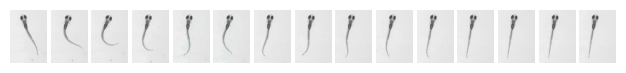

In [120]:
fig, axes = plt.subplots(1, len(chosen_inds), facecolor='None',figsize=(15.4*cm_, 2.6*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')
    ax.set_xlim(body_x[frame_n] + 140, body_x[frame_n] - 200)
    ax.set_ylim(body_y[frame_n] - 350, body_y[frame_n] + 140)
    ax.axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_tp.pdf', dpi=dpi)


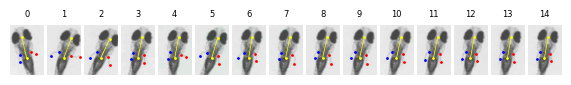

In [121]:
fig, axes = plt.subplots(1, len(chosen_inds),  facecolor='None',figsize=(14*cm_, 2*cm_), sharex=False, sharey=False)
axes = axes.ravel()

for ax_idx, ax in enumerate(axes):
    frame_n = bout_frame + chosen_inds[ax_idx]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    ax.imshow(out, alpha=0.9, cmap='gray', origin='lower')
    
    # Plot keypoints
    ax.scatter(body_x[frame_n], body_y[frame_n], c='yellow', s=size)
    ax.scatter(mid_headx[frame_n], mid_heady[frame_n], c='yellow', s=size)
    ax.plot([mid_headx[frame_n], body_x[frame_n]],[mid_heady[frame_n], body_y[frame_n]],'yellow', lw=lw)
    ax.scatter(left_fin_tip_x[frame_n], left_fin_tip_y[frame_n], s=size, color='b')
    ax.scatter(left_fin_base_x[frame_n], left_fin_base_y[frame_n], s=size, color='b')
    ax.scatter(right_fin_tip_x[frame_n], right_fin_tip_y[frame_n], s=size, color='r')
    ax.scatter(right_fin_base_x[frame_n], right_fin_base_y[frame_n], s=size, color='r')
    ax.set_xlim(body_x[frame_n] + 50, body_x[frame_n] - 50)
    ax.set_ylim(body_y[frame_n] - 50, body_y[frame_n] + 100)
    ax.set_title('{}'.format(ax_idx), fontsize=f_size)
    ax.axis('off')
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_img_zoom_tp.pdf', dpi=dpi)

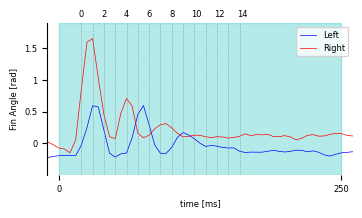

In [122]:
ylim=1.9
alph=0.3
# Calculate the starting frame of the bout
bout_frame_n = df.index[data['segments_on'][bout]]

# Calculate the starting frame of the bout
bout_frame_n = df.index[data['segments_on'][bout]]
fig, ax = plt.subplots(figsize=(10*cm_,5*cm_), facecolor='None', sharex=True)
ax.plot(smoothed_l_fin * -1, lw=lw, c='blue', label='Left')
ax.plot(smoothed_r_fin, lw=lw, c='red', label='Right')
ax.set_ylim(-0.5, ylim)
ax.set_ylabel('Fin Angle [rad]', fontsize=f_size)
ax.set_xticks([])
for indx, onset in enumerate(data['segments_on']):
    ax.axvspan(onset, onset + 50, color=color[bout_cat[indx]], alpha=alph)

# Add legend
ax.legend(fontsize=f_size)

for ind, i in enumerate(chosen_inds):
    frame_n = bout_frame_n + i
    ax.axvline(frame_n, c='gray', ls=':', lw=lw)    
    if ind % 2 == 0:  # This will label lines at even indices; use `ind % 2 == 1` for odd indices
        plt.text(frame_n - 0.5, ylim+0.1, ind, rotation=0, fontsize=f_size)

# Set x-axis labels and ticks
ax.set_xlabel('time [ms]', fontsize=f_size)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=f_size)
ax.set_xticks([bout_frame_n, bout_frame_n+50])
ax.set_xticklabels(['0', '250'], fontsize=f_size)
plt.xlim(bout_frame_n-2, bout_frame_n+52)

# Remove the top and right spines
sns.despine(top=True, right=True, left=False, bottom=True)

fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.png', dpi=dpi)
fig.savefig(figure_path / f'bout_{bout}_{labels_cat[bout_cat[bout]]}_fins_zoom_tp.pdf', dpi=dpi)